# Forecaster Model Testing

This notebook tests the ARIMA forecaster and Prometheus query integration.

**Steps:**
1. Query metric data from Prometheus
2. Train an ARIMA model on the retrieved data
3. Generate predictions and evaluate results


## 1. Setup and Imports


In [1]:
import sys
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import logging


# Add the forecast module to the path
sys.path.insert(0, str(Path.cwd()))

from prometheus_query import PrometheusClient
from arima_forecaster import ARIMAForecaster

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

print("✓ Imports successful")


✓ Imports successful


## 2. Configure Prometheus Connection


In [2]:
# Prometheus configuration
PROMETHEUS_URL = os.getenv('PROMETHEUS_URL', 'http://host.docker.internal:9090')

# Initialize Prometheus client
prom_client = PrometheusClient(base_url=PROMETHEUS_URL, timeout=15.0)

# Check health
if prom_client.is_healthy():
    print(f"✓ Successfully connected to Prometheus at {PROMETHEUS_URL}")
else:
    print(f"⚠ Warning: Cannot connect to Prometheus at {PROMETHEUS_URL}")
    print("  Make sure Prometheus is running (docker compose up -d)")


✓ Successfully connected to Prometheus at http://host.docker.internal:9090


## 3. Discover Available Metrics


In [3]:
# Discover metrics (looking for interface-related metrics)
metrics = prom_client.discover_metrics('interface')
logger.debug("Discovery found %d metrics (eligible=%d)", len(metrics))
print(f"Found {len(metrics)} metrics with 'interface' prefix:")
for metric in metrics[:10]:  # Show first 10
    print(f"  - {metric}")

if len(metrics) > 10:
    print(f"  ... and {len(metrics) - 10} more")


Found 4 metrics with 'interface' prefix:
  - interface_recv_octets
  - interface_recv_packets
  - interface_send_octets
  - interface_send_packets


## 4. Select a Metric and Query Series


In [4]:
# Select a metric to work with
# Try 'interface_recv_octets' or the first available metric
if 'interface_recv_octets' in metrics:
    selected_metric = 'interface_recv_octets'
elif metrics:
    selected_metric = metrics[0]
else:
    selected_metric = 'interface_recv_octets'  # Fallback

print(f"Selected metric: {selected_metric}")

# List available series for this metric
series_list = prom_client.list_series(selected_metric, lookback_minutes=120)

print(f"\nFound {len(series_list)} time series for '{selected_metric}':")
for i, series in enumerate(series_list[:5], 1):
    labels_str = ', '.join(f"{k}={v}" for k, v in series.items() if k != '__name__')
    print(f"  {i}. {{{labels_str}}}")

if len(series_list) > 5:
    print(f"  ... and {len(series_list) - 5} more")


Selected metric: interface_recv_octets

Found 14 time series for 'interface_recv_octets':
  1. {hostname=edge1, instance=host.docker.internal:19100, interface_name=ifNotify_ens2f0, job=udp-receiver}
  2. {hostname=edge1, instance=host.docker.internal:19100, interface_name=ifNotify_ens2f1, job=udp-receiver}
  3. {hostname=edge1, instance=host.docker.internal:19100, interface_name=nni0_in, job=udp-receiver}
  4. {hostname=edge1, instance=host.docker.internal:19100, interface_name=nni0_out, job=udp-receiver}
  5. {hostname=edge1, instance=host.docker.internal:19100, interface_name=nni1_in, job=udp-receiver}
  ... and 9 more


## 5. Query Historical Data


In [5]:
# Select the first available series
if series_list:
    selected_labels = {k: v for k, v in series_list[6].items() if k != '__name__'}
else:
    # Fallback labels if no series found
    selected_labels = {
        'hostname': 'edge1',
        'interface_name': 'ens2f0',
        'instance': 'host.docker.internal:19100',
        'job': 'udp-receiver'
    }
    print("No series found, using fallback labels")

print(f"\nQuerying data for labels: {selected_labels}")

# Query parameters
QUERY_LOOKBACK_MINUTES = 180  # 3 hours of historical data
QUERY_HORIZON_MINUTES = 15  # 30 minutes prediction horizon
STEP_SECONDS = 10      # 10-second resolution

# Fetch historical data
history_df = prom_client.get_metric_history(
    metric=selected_metric,
    labels=selected_labels,
    lookback_minutes=QUERY_LOOKBACK_MINUTES,
    step_seconds=STEP_SECONDS,
    horizon_minutes=QUERY_HORIZON_MINUTES
)

print(f"\n✓ Retrieved {len(history_df)} data points")
print(f"  Time range: {history_df['timestamp'].min()} to {history_df['timestamp'].max()}")
print(f"\nFirst few rows:")
print(history_df.head())
print(f"\nData summary:")
print(history_df['value'].describe())



Querying data for labels: {'hostname': 'edge1', 'instance': 'host.docker.internal:19100', 'interface_name': 'uni_rx', 'job': 'udp-receiver'}

✓ Retrieved 2336 data points
  Time range: 2025-10-28 04:55:40+00:00 to 2025-10-28 11:25:40+00:00

First few rows:
                  timestamp      value
0 2025-10-28 04:55:40+00:00  5209994.0
1 2025-10-28 04:55:50+00:00  5210820.0
2 2025-10-28 04:56:00+00:00  5211800.0
3 2025-10-28 04:56:10+00:00  5212780.0
4 2025-10-28 04:56:20+00:00  5213410.0

Data summary:
count    2.336000e+03
mean     6.277773e+06
std      6.343020e+05
min      5.209994e+06
25%      5.727329e+06
50%      6.254961e+06
75%      6.828278e+06
max      7.398922e+06
Name: value, dtype: float64


## 6. Visualize Historical Data


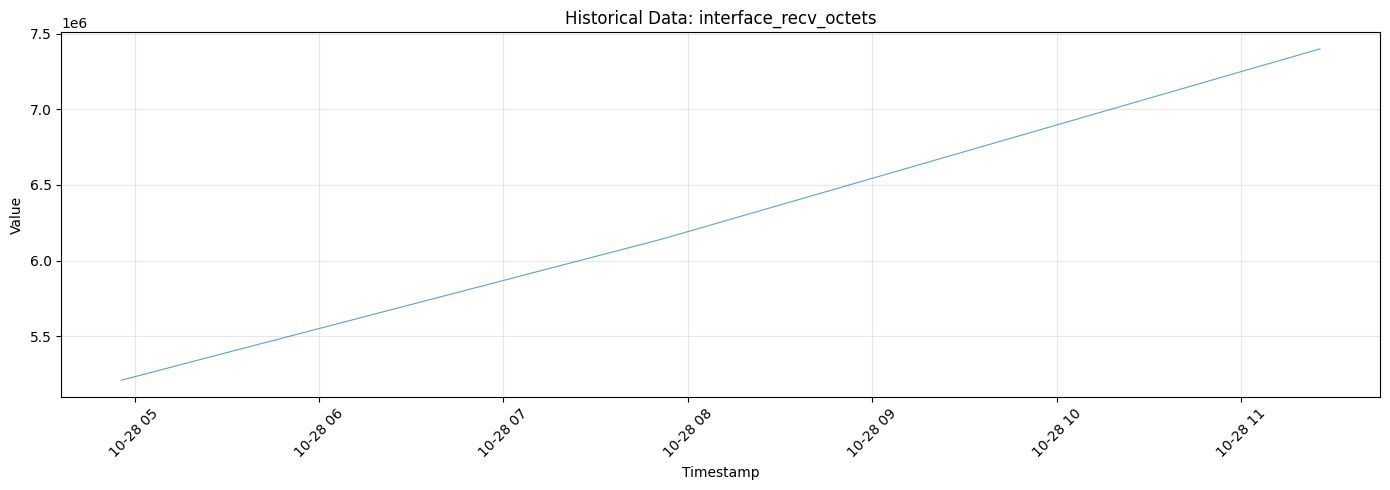

In [6]:
if len(history_df) > 0:
    plt.figure(figsize=(14, 5))
    plt.plot(history_df['timestamp'], history_df['value'], linewidth=0.8, alpha=0.7)
    plt.title(f'Historical Data: {selected_metric}')
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("⚠ No data to visualize")


## 7. Initialize Forecaster and Train Model


In [7]:
# Set environment variables for forecaster configuration
os.environ['FORECAST_LOOKBACK_MINUTES'] = '180'
os.environ['FORECAST_HORIZON_MINUTES'] = '15'
os.environ['FORECAST_CADENCE_SECONDS'] = '10'
os.environ['FORECAST_ARIMA_ORDER'] = '2,1,2'

# Initialize forecaster
forecaster = ARIMAForecaster()

print(f"✓ Forecaster initialized")
print(f"  Lookback: {forecaster.lookback_minutes} minutes ({forecaster.lookback_points()} points)")
print(f"  Horizon: {forecaster.horizon_minutes} minutes ({forecaster.horizon_points()} points)")
print(f"  Cadence: {forecaster.cadence_seconds} seconds")


2025-10-28 12:25:51,787 - arima_forecaster - WARNING - Model directory /home/peti/networking-dashboard/docker_setup/forecaster_models exists but is not writable
2025-10-28 12:25:51,788 - arima_forecaster - INFO - Using fallback model directory at /home/peti/.cache/networking-dashboard/forecaster_models
2025-10-28 12:25:51,789 - arima_forecaster - INFO - ARIMAForecaster initialised (order=(2, 1, 2) lookback=180min horizon=15min cadence=10sec models=/home/peti/.cache/networking-dashboard/forecaster_models)


✓ Forecaster initialized
  Lookback: 180 minutes (1080 points)
  Horizon: 15 minutes (90 points)
  Cadence: 10 seconds


In [8]:
# Train the model
if len(history_df) >= forecaster.lookback_points() + forecaster.horizon_points():
    print("\nTraining model...\n")
    
    training_result = forecaster.train(
        metric=selected_metric,
        labels=selected_labels,
        history=history_df
    )
    
    print("\n✓ Training completed!")
    print(f"  Version: {training_result['version']}")
    print(f"  RMSE: {training_result['rmse']:.4f}")
    print(f"  Residual Std: {training_result['residual_std']:.4f}")
    print(f"  Promoted: {training_result['promoted']}")
    print(f"  Trained at: {training_result['trained_at']}")
else:
    print(f"⚠ Insufficient data for training")
    print(f"  Need at least {forecaster.lookback_points() + forecaster.horizon_points()} points")
    print(f"  Have: {len(history_df)} points")
    training_result = None


2025-10-28 12:26:00,330 - arima_forecaster - INFO - Training ARIMA model for interface_recv_octets/d27a8c185e43ff5d (samples=2336)
/home/peti/networking-dashboard/app/forecast/arima_forecaster.py:346: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')
2025-10-28 12:26:00,390 - arima_forecaster - INFO - Stationarity test: ADF=False (p=0.9935), KPSS=False (p=0.0100) -> stationary=False
2025-10-28 12:26:00,391 - arima_forecaster - INFO - Applying first-order differencing to make series stationary
/home/peti/networking-dashboard/app/forecast/arima_forecaster.py:346: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')
2025-10-28 12:26:00,436 - arim


Training model...



2025-10-28 12:26:02,938 - arima_forecaster - INFO - New model for interface_recv_octets/d27a8c185e43ff5d not promoted; rmse 90.2220 worse than 81.4340
2025-10-28 12:26:02,940 - arima_forecaster - INFO - Training completed for interface_recv_octets/d27a8c185e43ff5d version=v20251028-1126 rmse=90.2220 baseline_w=0.00 promoted=False



✓ Training completed!
  Version: v20251028-1126
  RMSE: 90.2220
  Residual Std: 90.2220
  Promoted: False
  Trained at: 2025-10-28T11:26:02.919379+00:00


## 8. Generate Predictions


In [9]:
if training_result and len(history_df) > 0:
    print("Generating prediction...\n")
    
    prediction = forecaster.predict(
        metric=selected_metric,
        labels=selected_labels,
        history=history_df
    )
    
    print("✓ Prediction results:")
    print(f"  Point forecast: {prediction['point_forecast']:.2f}")
    
    if prediction['confidence_interval']:
        lower, upper = prediction['confidence_interval']
        print(f"  95% Confidence interval: [{lower:.2f}, {upper:.2f}]")
        print(f"  Interval width: {upper - lower:.2f}")
    
    print(f"  Model version: {prediction['model_version']}")
    
    # Calculate some context
    recent_mean = history_df['value'].tail(forecaster.lookback_points()).mean()
    recent_std = history_df['value'].tail(forecaster.lookback_points()).std()
    
    print(f"\nComparison with recent data:")
    print(f"  Recent mean: {recent_mean:.2f}")
    print(f"  Recent std: {recent_std:.2f}")
    print(f"  Prediction vs mean: {((prediction['point_forecast'] - recent_mean) / recent_mean * 100):.1f}% difference")
else:
    print("⚠ Skipping prediction (training failed or no data)")
    prediction = None


Generating prediction...

✓ Prediction results:
  Point forecast: 7252341.50
  95% Confidence interval: [7251958.01, 7252725.31]
  Interval width: 767.30
  Model version: v20251027-1400

Comparison with recent data:
  Recent mean: 6632318.27
  Recent std: 307517.56
  Prediction vs mean: 9.3% difference


## 9. Visualize Prediction


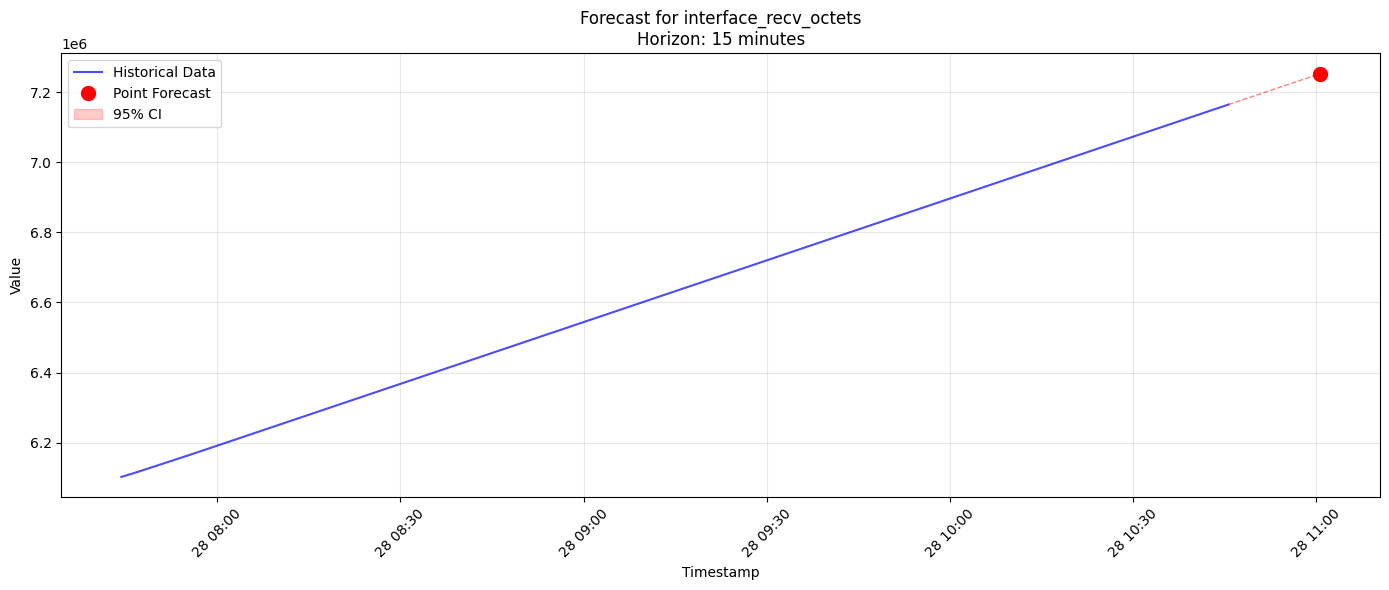

In [10]:
if prediction and len(history_df) > 0:
    # Get the last N points for context
    lookback_data = history_df.tail(forecaster.lookback_points())
    
    # Create prediction point at the horizon
    last_timestamp = history_df['timestamp'].max()
    forecast_timestamp = last_timestamp + pd.Timedelta(minutes=forecaster.horizon_minutes)
    
    plt.figure(figsize=(14, 6))
    
    # Plot historical data
    plt.plot(lookback_data['timestamp'], lookback_data['value'], 
             'b-', linewidth=1.5, alpha=0.7, label='Historical Data')
    
    # Plot prediction point
    plt.plot([forecast_timestamp], [prediction['point_forecast']], 
             'ro', markersize=10, label='Point Forecast', zorder=5)
    
    # Plot confidence interval if available
    if prediction['confidence_interval']:
        lower, upper = prediction['confidence_interval']
        plt.fill_between([forecast_timestamp], [lower], [upper], 
                        color='red', alpha=0.2, label='95% CI')
        plt.plot([forecast_timestamp, forecast_timestamp], [lower, upper], 
                'r--', linewidth=1.5, alpha=0.5)
    
    # Connect last point to forecast
    plt.plot([last_timestamp, forecast_timestamp], 
             [lookback_data['value'].iloc[-1], prediction['point_forecast']], 
             'r--', linewidth=1, alpha=0.5)
    
    plt.title(f'Forecast for {selected_metric}\nHorizon: {forecaster.horizon_minutes} minutes')
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("⚠ No prediction to visualize")


## 10. List All Trained Models


In [ ]:
# List all models in the system
all_models = forecaster.list_models()

print(f"Total trained models: {len(all_models)}\n")

if all_models:
    for i, model_info in enumerate(all_models[:10], 1):
        print(f"{i}. {model_info['metric']}")
        print(f"   Labels: {model_info.get('label_hash', 'N/A')}")
        print(f"   Version: {model_info.get('version', 'N/A')}")
        print(f"   RMSE: {model_info.get('rmse', 0):.4f}")
        print(f"   Trained: {model_info.get('trained_at', 'N/A')}")
        print()
    
    if len(all_models) > 10:
        print(f"... and {len(all_models) - 10} more models")
else:
    print("No models found in the system")


## Summary

This notebook demonstrated:
1. ✓ Connecting to Prometheus and discovering metrics
2. ✓ Querying historical time series data
3. ✓ Training an ARIMA forecasting model
4. ✓ Generating predictions with confidence intervals
5. ✓ Visualizing results

The forecaster is now ready to use in production!
